In [1]:
import sys
sys.path.insert(0, '../')
from gw_tools.gw_plot import gw_plot
from gw_tools import data_prep
from gw_tools.gw_LSTM import gw_LSTM

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

2023-11-23 17:30:34.851405: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-23 17:30:34.884104: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-23 17:30:34.884130: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-23 17:30:34.884157: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-23 17:30:34.890259: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-23 17:30:34.890640: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

In [11]:
## Define CNN parameters for individual wells
LSTM_params_AEK201 = {'model__CHECKPOINT': False,
                        'model__D_MAX_LAYERS': 8,
                        'model__D_MIN_UNITS': 3,
                        'model__D_TOP_UNITS': 30,
                        'model__D_UNIT_SCALE': 0.1,
                        'model__EPOCHS': 30,
                        'model__LEARNING_RATE': 0.001,
                        'model__LSTM_UNITS': 64,
                        'model__NUM_FEATS': 12,
                        'model__RANDOM_STATE': 90210,
                        'model__WINDOW_SIZE': 14}


LSTM_params_AFL259 = {'model__CHECKPOINT': False,
                        'model__D_MAX_LAYERS': 1,
                        'model__D_MIN_UNITS': 2,
                        'model__D_TOP_UNITS': 8,
                        'model__D_UNIT_SCALE': 0.5,
                        'model__EPOCHS': 30,
                        'model__LEARNING_RATE': 0.0005,
                        'model__LSTM_UNITS': 64,
                        'model__NUM_FEATS': 12,
                        'model__RANDOM_STATE': 90210,
                        'model__WINDOW_SIZE': 14}


LSTM_params_APK309 = {'model__CHECKPOINT': False,
                        'model__D_MAX_LAYERS': 8,
                        'model__D_MIN_UNITS': 3,
                        'model__D_TOP_UNITS': 30,
                        'model__D_UNIT_SCALE': 0.1,
                        'model__EPOCHS': 30,
                        'model__LEARNING_RATE': 0.0005,
                        'model__LSTM_UNITS': 32,
                        'model__NUM_FEATS': 12,
                        'model__RANDOM_STATE': 90210,
                        'model__WINDOW_SIZE': 45}


LSTM_params_APK310 = {'model__CHECKPOINT': False,
                        'model__D_MAX_LAYERS': 8,
                        'model__D_MIN_UNITS': 3,
                        'model__D_TOP_UNITS': 150,
                        'model__D_UNIT_SCALE': 0.1,
                        'model__EPOCHS': 30,
                        'model__LEARNING_RATE': 0.0005,
                        'model__LSTM_UNITS': 64,
                        'model__NUM_FEATS': 12,
                        'model__RANDOM_STATE': 90210,
                        'model__WINDOW_SIZE': 60}

well_params = [LSTM_params_AEK201, LSTM_params_AFL259, LSTM_params_APK309, LSTM_params_APK310]

In [12]:
wells = ['AEK201', 'AFL259', 'APK309', 'APK310']
def LSTM_standard_prep(well,params):
    ## Load cleaned data
    df = data_prep.load_data(well)
    ## Select features for training
    df = data_prep.select_features(df)
    ## Add time of year signal information
    df = data_prep.add_toy_signal(df)
    ## Set aside holdout data for final model validation
    return data_prep.LSTM_data_prep(df,params['model__WINDOW_SIZE']), df.date.values.copy()

# Long Short Term Memory

One of the deep learning frameworks we implemented for this project is a Long Short Term Memory (LSTM) recursive neural network. 

Because Scikit-Learn does not have any modules for contructing LSTMs, we turned to packeges provided by tensorflow to build our newtork. We were still intersted in using Scikit-Learn tools like Pipeline and GridSearchCV, so we needed to make a custom Scikit-Learn Estimator/Transformser to make the `fit` and `predict` functions of our model accessible them.



In [13]:
## For scaling the data
scaler =  StandardScaler(copy=True)

ytrains={}
yhos={}
date_ranges={}
preds={}
rmses={}

wells=['AFL259']
well_params = [LSTM_params_AFL259]
for well, params in zip(wells, well_params):
    ## Prepare the training and holdout data
    (X_tr_L, X_te_L, well_tr_mean, well_tr_std), dates = LSTM_standard_prep(well, params)
    y_train = X_tr_L.avg_well_depth
    y_holdout = X_te_L.avg_well_depth[params['model__WINDOW_SIZE']:]
    
    ## Instantiate the model
    model = gw_LSTM()
    
    ## Set up the pipeline
    pipe = Pipeline([('scaler', scaler), ('model', model)])
    
    ## Set the parameters
    params['model__tmean'] = well_tr_mean
    params['model__tsd'] = well_tr_std
    pipe.set_params(**params)
    
    ## Fit the model
    pipe.fit(X_tr_L, y_train)
    
    ## Make predictions
    pred = pipe.predict(X_te_L)
    
    ## Compute RMSE
    mse = np.mean((pred-y_holdout)**2)
    rmse = np.sqrt(mse)
    
    ## Store results
    ytrains[well] = y_train
    yhos[well] = y_holdout
    date_ranges[well] = dates
    preds[well] = pred
    rmses[well] = rmse

/home/meredith/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/meredith/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/meredith/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/meredith/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isi

Epoch 1/30
124/124 [==============================] - 2s 2ms/step - loss: 7248.3364 - root_mean_squared_error: 85.1372
Epoch 2/30
124/124 [==============================] - 0s 2ms/step - loss: 1613.3104 - root_mean_squared_error: 40.1660
Epoch 3/30
124/124 [==============================] - 0s 2ms/step - loss: 78.1354 - root_mean_squared_error: 8.8394
Epoch 4/30
124/124 [==============================] - 0s 2ms/step - loss: 9.9872 - root_mean_squared_error: 3.1602
Epoch 5/30
124/124 [==============================] - 0s 2ms/step - loss: 8.2631 - root_mean_squared_error: 2.8746
Epoch 6/30
124/124 [==============================] - 0s 2ms/step - loss: 7.4141 - root_mean_squared_error: 2.7229
Epoch 7/30
124/124 [==============================] - 0s 2ms/step - loss: 5.3473 - root_mean_squared_error: 2.3124
Epoch 8/30
124/124 [==============================] - 0s 2ms/step - loss: 4.1755 - root_mean_squared_error: 2.0434
Epoch 9/30
124/124 [==============================] - 0s 2ms/step - los

/home/meredith/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/meredith/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/meredith/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step


On the holdout set for AFL259, the predictions made using LSTM exhibited a root mean squared of 65.870317829856


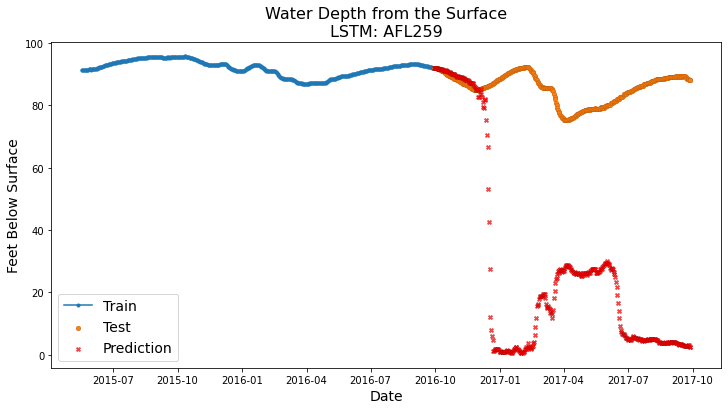

In [14]:
for well in wells:
    ## Print results
    print(f'On the holdout set for {well}, the predictions made using LSTM exhibited a root mean squared of {rmses[well]}')
    ## Plot results
    gw_plot(train = ytrains[well], 
            test = yhos[well], 
            pred = preds[well], 
            dates = date_ranges[well], 
            train_limit=500, model='LSTM: '+well)